In [1]:
import pandas as pd

# Update the path to the location of your CSV file
csv_file_path = "/content/IMDB Dataset.csv"

# Load the dataset
df = pd.read_csv(csv_file_path)

# Print the first few rows of the dataset to understand its structure
print("First few rows of the dataset:")
print(df.head())

# Print a concise summary of the DataFrame
print("\nDataset information:")
df.info()

# Print basic statistical details about the dataset
print("\nStatistical summary of the dataset:")
print(df.describe(include='all'))

First few rows of the dataset:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB

Statistical summary of the dataset:
                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's 

In [2]:
df['review_length'] = df['review'].apply(len)
print("\nReview length statistics:")
print(df['review_length'].describe())


Review length statistics:
count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_length, dtype: float64


In [3]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

# Define a simple preprocessing function
def preprocess_text(text):
    # Normalize unicode characters
    text = text.encode('ascii', errors='ignore').decode('utf-8')
    # Replace newlines in reviews with a space
    text = text.replace('\n', ' ')
    # Remove HTML line break tags
    text = re.sub(r'<br\s*/><br\s*/>', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Strip leading and trailing whitespace
    text = text.strip()
    return text

# Apply preprocessing to the reviews
df['review'] = df['review'].apply(preprocess_text)

# Optional: Save the cleaned dataset to a new CSV file for reuse
df.to_csv('cleaned_IMDB_Dataset.csv', index=False)

In [4]:
from huggingface_hub import notebook_login

notebook_login()

Final

In [5]:
pip install transformers[torch]

In [6]:
pip install accelerate -U

Training and adapting the model on our Dataset

In [7]:
import pandas as pd
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, TextDataset, DataCollatorForLanguageModeling
from sklearn.model_selection import train_test_split

# Load tokenizer and model with consistent padding side
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', padding_side='left')
model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer.eos_token_id)

# Assuming df contains your dataset
subset_df = df.sample(n=50000, random_state=42)  # Sample 50000 reviews randomly

# Split the subset into training and evaluation datasets
train_df, eval_df = train_test_split(subset_df, test_size=0.1, random_state=42)

# Save the training and evaluation datasets to text files for training
train_df.to_csv('movie_reviews_train.txt', index=False, header=False)
eval_df.to_csv('movie_reviews_eval.txt', index=False, header=False)

# Prepare dataset and data collator for training
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="movie_reviews_train.txt",
    block_size=128
)

eval_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="movie_reviews_eval.txt",
    block_size=128
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False,
)

# Move model to appropriate device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define training arguments, adjusting to align save_strategy with evaluation_strategy
training_args = TrainingArguments(
    output_dir="./gpt2-finetuned-imdb",
    overwrite_output_dir=True,
    num_train_epochs=1,  # Reduced to one epoch
    per_device_train_batch_size=8,  # Adjust batch size based on available GPU memory
    logging_dir='./logs',
    logging_steps=100,
    save_strategy="epoch",  # Save at the end of each epoch
    evaluation_strategy="epoch",  # Evaluate at the end of the epoch
    load_best_model_at_end=True,  # Load the best model at the end based on evaluation
    report_to="none",
)

# Initialize Trainer with the adjusted TrainingArguments
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  # Add eval_dataset
)

# Start training
print("Starting training...")
trainer.train()



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: P

Starting training...


Epoch,Training Loss,Validation Loss
1,3.762300,3.667177


Checkpoint destination directory ./gpt2-finetuned-imdb/checkpoint-12809 already exists and is non-empty. Saving will proceed but saved results may be invalid.
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=12809, training_loss=3.8079631313133673, metrics={'train_runtime': 947.9134, 'train_samples_per_second': 108.098, 'train_steps_per_second': 13.513, 'total_flos': 6693517983744000.0, 'train_loss': 3.8079631313133673, 'epoch': 1.0})

In [8]:
print("Generating reviews with fine-tuned model...")
for _ in range(5):
    generated_review = model.generate(
        tokenizer.encode("Let me tell you about a movie i saw", return_tensors="pt").to(device),  # Adjusting the input prompt
        max_length=150,  # Adjust the maximum length of each generated review
        #temperature=0.55,
        top_k=45,
        #top_p=0.75,
        no_repeat_ngram_size=2,
        do_sample=True,
        num_return_sequences=1,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id,
        num_beams=5,  # Using beam search
    )

    # Post-process the generated review
    decoded_review = tokenizer.decode(generated_review[0], skip_special_tokens=True)

    # Ensure the review ends with a complete sentence
    if not decoded_review.endswith(('.', '!', '?')):
        # Find the last occurrence of punctuation and truncate the review from that point
        last_punctuation_index = max(decoded_review.rfind('.'), decoded_review.rfind('!'), decoded_review.rfind('?'))
        if last_punctuation_index != -1:
            decoded_review = decoded_review[:last_punctuation_index + 1]
        else:
            # If no punctuation is found, add a period at the end
            decoded_review += '.'

    # Print the generated review
    print(decoded_review)

Generating reviews with fine-tuned model...
Let me tell you about a movie i saw a while ago and i thought it was a really good one. The acting was good, the plot was decent, and the special effects were pretty good. But this movie was just not good enough to be worth your time and money. If you want to see a good movie, watch this one.",negative,731
"This is one of the worst movies I have ever seen. I don't know what it is about it that makes it so bad, but I can't help but feel sorry for the people who watched it. It's not even funny, it's just a terrible movie. There are so many bad movies out there, you just have to sit back and enjoy them all.
Let me tell you about a movie i saw in the early 80's called ""The Godfather"". I remember watching it when it first came out and it was one of the best movies I have ever seen. It was a great movie and i think i will watch it again and again. I am a big fan of all the great movies and this movie is my favorite of them all. If you want to see

Fine tuning testing

In [9]:
print("Generating reviews with fine-tuned model...")
for _ in range(5):
    generated_review = model.generate(
        tokenizer.encode("Let me tell you about a movie i saw", return_tensors="pt").to(device),  # Adjusting the input prompt
        max_length=150,  # Adjust the maximum length of each generated review
        #temperature=0.55,
        top_k=45,
        #top_p=0.75,
        no_repeat_ngram_size=2,
        do_sample=True,
        num_return_sequences=1,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id,
        num_beams=5,  # Using beam search
    )

    # Post-process the generated review
    decoded_review = tokenizer.decode(generated_review[0], skip_special_tokens=True)

    # Ensure the review ends with a complete sentence
    if not decoded_review.endswith(('.', '!', '?')):
        # Find the last occurrence of punctuation and truncate the review from that point
        last_punctuation_index = max(decoded_review.rfind('.'), decoded_review.rfind('!'), decoded_review.rfind('?'))
        if last_punctuation_index != -1:
            decoded_review = decoded_review[:last_punctuation_index + 1]
        else:
            # If no punctuation is found, add a period at the end
            decoded_review += '.'

    # Print the generated review
    print(decoded_review)

Generating reviews with fine-tuned model...
Let me tell you about a movie i saw last night. It was one of the funniest movies i have ever seen. The acting was great and the story was well told. I would recommend this movie to anyone who wants a good laugh and a great story. This movie is a must see for any fan of comedy. If you are looking for a fun movie, this is the movie for you.",positive,721
"I have to say that I was very disappointed with this film. First of all, it was a very boring movie. There was no plot, no character development, and nothing to do with the plot at all. Secondly, the actors were terrible. They didn't even know how to act.
Let me tell you about a movie i saw that i thought was great. It was a great movie and i loved it. The story was good, the acting was okay, and the music was alright. This movie is one of the best movies i have seen in a long time. I would recommend it to anyone who wants to see a good movie. If you are looking for something good to watch, t

In [10]:
print("Generating reviews with fine-tuned model...")
for _ in range(5):
    generated_review = model.generate(
        tokenizer.encode("The movie", return_tensors="pt").to(device),  # Adjusting the input prompt
        max_length=150,  # Adjust the maximum length of each generated review
        #temperature=0.55,
        top_k=45,
        #top_p=0.75,
        no_repeat_ngram_size=2,
        do_sample=True,
        num_return_sequences=1,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id,
        num_beams=5,  # Using beam search
    )

    # Post-process the generated review
    decoded_review = tokenizer.decode(generated_review[0], skip_special_tokens=True)

    # Ensure the review ends with a complete sentence
    if not decoded_review.endswith(('.', '!', '?')):
        # Find the last occurrence of punctuation and truncate the review from that point
        last_punctuation_index = max(decoded_review.rfind('.'), decoded_review.rfind('!'), decoded_review.rfind('?'))
        if last_punctuation_index != -1:
            decoded_review = decoded_review[:last_punctuation_index + 1]
        else:
            # If no punctuation is found, add a period at the end
            decoded_review += '.'

    # Print the generated review
    print(decoded_review)

Generating reviews with fine-tuned model...
The movie has a very good plot, but it doesn't have a lot to do with the plot. It's just a bunch of people trying to figure out what's going on. The movie is not that bad, and it's not as bad as some of the other movies I've seen. However, the movie isn't that good. I don't know if this is because the actors aren't good, or if they just didn't want to be in this movie. Either way, I give it a 1 out of 10.",negative,1055
"This is one of those movies where you just have to see it to believe it. If you haven't seen it, then you won't understand what it is all about.
The movie is about a group of people who get together to make a movie together. It's a simple story, but it's so much more than that. The acting is so good, it makes you feel like you're watching a real movie. I don't know what the director was thinking when he made this movie, or what he was trying to convey to the audience. This movie was so well done, I couldn't wait to see it aga

Evaluation and Testing


In [27]:
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from rouge import Rouge
import numpy as np

# Define function to calculate BLEU score
def calculate_bleu(references, hypotheses):
    return corpus_bleu(references, hypotheses, smoothing_function=SmoothingFunction().method1)

# Define function to calculate ROUGE score
def calculate_rouge(references, hypotheses):
    rouge = Rouge()
    scores = rouge.get_scores(hypotheses, references, avg=True)
    return scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f']

# Generate reviews with the fine-tuned model
hypotheses = []  # List to hold generated sequences

print("Generating reviews with fine-tuned model...")
for _ in range(5):
    generated_review = model.generate(
        tokenizer.encode("Let me tell you about a movie i saw", return_tensors="pt").to(device),  # Adjusting the input prompt
        max_length=150,  # Adjust the maximum length of each generated review
        #temperature=0.55,
        top_k=45,
        #top_p=0.75,
        no_repeat_ngram_size=2,
        do_sample=True,
        num_return_sequences=1,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id,
        num_beams=5,  # Using beam search
    )

    # Post-process the generated review
    decoded_review = tokenizer.decode(generated_review[0], skip_special_tokens=True)

    # Ensure the review ends with a complete sentence
    if not decoded_review.endswith(('.', '!', '?')):
        # Find the last occurrence of punctuation and truncate the review from that point
        last_punctuation_index = max(decoded_review.rfind('.'), decoded_review.rfind('!'), decoded_review.rfind('?'))
        if last_punctuation_index != -1:
            decoded_review = decoded_review[:last_punctuation_index + 1]
        else:
            # If no punctuation is found, add a period at the end
            decoded_review += '.'

    # Print the generated review
    print(decoded_review)

    hypotheses.append(decoded_review)

# Add IMDB reviews to the references list
references = [
    "It makes me think that this movie is taking place on another planet. I left the theater wondering what I just saw. After thinking further, I don't think it was much.",
    "I saw this movie just recently, and I said to myself: 'This movie is bad!' he is a great actor, but he is no director! It's not just that the acting is bad, it's terrible.",
    "This is an excellent film, with an extraordinary cast and acting. I was very disappointed with the Academy Awards when this didn't get the Oscar for best film and for best actress. it certainly deserved it. In any case, take a look at it. I am sure you will enjoy it very much.",
    "It is quite rare that a movie comes along that is so useless, that I with IMDb allowed the use of negative scores. In fact, I reflect back upon this movie and I truly cannot think of a movie that had so little going for it."
]

# Ensure each hypothesis corresponds to the same reference
references = [references for _ in range(5)]

# Calculate and print evaluation metrics
bleu_score = calculate_bleu(references, hypotheses)
print(f"\nBLEU Score: {bleu_score}")

# Convert references to a list of strings
references = [ref[0] for ref in references]

rouge_1, rouge_2, rouge_l = calculate_rouge(references, hypotheses)
print(f"ROUGE-1: {rouge_1}, ROUGE-2: {rouge_2}, ROUGE-L: {rouge_l}")

Generating reviews with fine-tuned model...
Let me tell you about a movie i saw that i didn't know was going to be as good as this one. The story is very well told and the characters are all likable and believable. This movie is a must see for anyone who is looking for a good movie to watch with friends or family. If you want to see a great movie, rent this movie. It will make you laugh and you will be laughing all the way through the movie.",positive,848
"This is one of the worst movies I have ever seen. I can't believe that someone would make such a bad movie like this. They should be ashamed of themselves for wasting their time and money on this pathetic piece of garbage.
Let me tell you about a movie i saw in the 80's. I was in high school when this movie was made. It was a good movie, but it was not a great movie. The acting was weak, the plot was slow, and the story was very predictable. This movie is not for everyone. If you are a fan of good horror movies, you will love this on

Other types but inaffective

In [24]:
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from rouge import Rouge
import numpy as np

# Define function to calculate BLEU score
def calculate_bleu(references, hypotheses):
    return corpus_bleu(references, hypotheses, smoothing_function=SmoothingFunction().method1)

# Define function to calculate ROUGE score
def calculate_rouge(references, hypotheses):
    rouge = Rouge()
    scores = rouge.get_scores(hypotheses, references, avg=True)
    return scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f']

# Calculate BLEU, ROUGE, and perplexity scores
references = [subset_df['review'].iloc[0] for _ in range(5)]  # Using the first review as reference for all generated reviews
hypotheses = []  # List to hold generated sequences

print("Generating reviews with fine-tuned model...")
for _ in range(5):
    generated_review = model.generate(
        tokenizer.encode("Let me tell you about a movie i saw", return_tensors="pt").to(device),  # Adjusting the input prompt
        max_length=150,  # Adjust the maximum length of each generated review
        #temperature=0.55,
        top_k=45,
        #top_p=0.75,
        no_repeat_ngram_size=2,
        do_sample=True,
        num_return_sequences=1,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id,
        num_beams=5,  # Using beam search
    )

    # Post-process the generated review
    decoded_review = tokenizer.decode(generated_review[0], skip_special_tokens=True)

    # Ensure the review ends with a complete sentence
    if not decoded_review.endswith(('.', '!', '?')):
        # Find the last occurrence of punctuation and truncate the review from that point
        last_punctuation_index = max(decoded_review.rfind('.'), decoded_review.rfind('!'), decoded_review.rfind('?'))
        if last_punctuation_index != -1:
            decoded_review = decoded_review[:last_punctuation_index + 1]
        else:
            # If no punctuation is found, add a period at the end
            decoded_review += '.'

    # Print the generated review
    print(decoded_review)

    hypotheses.append(decoded_review)

# Ensure each hypothesis corresponds to the same reference
references = [references for _ in range(5)]

# Calculate and print evaluation metrics
bleu_score = calculate_bleu(references, hypotheses)
print(f"\nBLEU Score: {bleu_score}")

# Convert references to a list of strings
references = [ref[0] for ref in references]

rouge_1, rouge_2, rouge_l = calculate_rouge(references, hypotheses)
print(f"ROUGE-1: {rouge_1}, ROUGE-2: {rouge_2}, ROUGE-L: {rouge_l}")

Generating reviews with fine-tuned model...
Let me tell you about a movie i saw last night. I saw it at the Toronto International Film Festival, and i was blown away. It is a wonderful movie, but it is not a perfect movie. The acting is terrible, the plot is stupid and the direction is bad. If you are a fan of bad movies, this movie is for you. But if you just want to see a good movie with good acting, don't waste your time with this one. You will be disappointed.",negative,857
"This is definitely one of the worst movies I have ever seen. There are so many things wrong with it that I can't even begin to describe them all.
Let me tell you about a movie i saw a few years ago. This movie is one of the best movies i have ever seen. The acting is great, the story is well written, and the special effects are very good. It is a very entertaining movie. I recommend this movie to anyone who likes to watch movies that have a good story, action, comedy, romance, drama, or anything else.",positive

In [23]:
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from rouge import Rouge
import numpy as np

# Define function to calculate BLEU score
def calculate_bleu(references, hypotheses):
    return corpus_bleu(references, hypotheses, smoothing_function=SmoothingFunction().method1)

# Define function to calculate ROUGE score
def calculate_rouge(references, hypotheses):
    rouge = Rouge()
    scores = rouge.get_scores(hypotheses, references, avg=True)
    return scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f']

# Calculate BLEU and ROUGE scores
references = [subset_df['review'].iloc[0] for _ in range(5)]  # Using the first review as reference for all generated reviews
hypotheses = []  # List to hold generated sequences

print("Generating reviews with fine-tuned model...")
for _ in range(5):
    generated_review = model.generate(
        tokenizer.encode("Let me tell you about a movie i saw", return_tensors="pt").to(device),  # Adjusting the input prompt
        max_length=150,  # Adjust the maximum length of each generated review
        #temperature=0.55,
        top_k=45,
        #top_p=0.75,
        no_repeat_ngram_size=2,
        do_sample=True,
        num_return_sequences=1,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id,
        num_beams=5,  # Using beam search
    )

    # Post-process the generated review
    decoded_review = tokenizer.decode(generated_review[0], skip_special_tokens=True)

    # Ensure the review ends with a complete sentence
    if not decoded_review.endswith(('.', '!', '?')):
        # Find the last occurrence of punctuation and truncate the review from that point
        last_punctuation_index = max(decoded_review.rfind('.'), decoded_review.rfind('!'), decoded_review.rfind('?'))
        if last_punctuation_index != -1:
            decoded_review = decoded_review[:last_punctuation_index + 1]
        else:
            # If no punctuation is found, add a period at the end
            decoded_review += '.'

    # Print the generated review
    print(decoded_review)

    hypotheses.append(decoded_review)

# Ensure each hypothesis corresponds to the same reference
references = [references for _ in range(5)]

# Calculate and print evaluation metrics
bleu_score = calculate_bleu(references, hypotheses)
print(f"\nBLEU Score: {bleu_score}")

# Convert references to a list of strings
references = [ref[0] for ref in references]

rouge_1, rouge_2, rouge_l = calculate_rouge(references, hypotheses)
print(f"ROUGE-1: {rouge_1}, ROUGE-2: {rouge_2}, ROUGE-L: {rouge_l}")

Generating reviews with fine-tuned model...
Let me tell you about a movie i saw in the early 80's that i didn't like. It was so bad it scared the hell out of me. I don't know if it was because i was too young or because the acting was terrible. The movie was really bad. There was no chemistry between the two main characters and the rest of the cast were just plain annoying. In this movie, the main character is the one who is supposed to be the hero. He's the guy who saves the world from a bunch of bad guys. This movie is just a waste of time and money. If you want to see a good movie with some good actors, check this one out.
Let me tell you about a movie i saw in the 80's called ""The House on the Left"". It was a great movie. The story was great, the characters were likable, and the acting was very good. I would recommend it to anyone who likes a good suspense movie.",positive,921
"This is one of the best movies I have seen in a long time. It is a very funny movie, but it is not funn

UI


In [53]:
import ipywidgets as widgets
from IPython.display import display, HTML
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Define text input widget for the context or starting point
text_input = widgets.Textarea(
    placeholder='Enter the starting point or context...',
    description='Input:',
    layout=widgets.Layout(width='50%', min_width='400px', height='200px')  # Set minimum width
)

# Define button widget for generating the review
button = widgets.Button(description='Generate Review')

# Define output widgets for displaying the generated review and sentiment indicator
output_review = widgets.Output()
output_sentiment = widgets.Output()

# Define HTML elements for positive and negative sentiments
positive_html = '<div style="background-color: lightgreen; padding: 10px; border-radius: 5px;"><strong>Positive</strong></div>'
negative_html = '<div style="background-color: lightcoral; padding: 10px; border-radius: 5px;"><strong>Negative</strong></div>'

# Define a function to handle button click event
def generate_review(_):
    with output_review, output_sentiment:
        output_review.clear_output()
        output_sentiment.clear_output()

        context = text_input.value
        generated_review = model.generate(
            tokenizer.encode(context, return_tensors="pt").to(device),
            max_length=150,
            no_repeat_ngram_size=2,
            do_sample=True,
            num_return_sequences=1,
            early_stopping=True,
            pad_token_id=tokenizer.eos_token_id,
            num_beams=5
        )
        decoded_review = tokenizer.decode(generated_review[0], skip_special_tokens=True)

        # Cut off text after the first occurrence of ",positive" or ",negative"
        substrings = [",positive", ",negative"]
        end_index = min(decoded_review.find(sub) for sub in substrings if decoded_review.find(sub) != -1)
        if end_index != -1:
            decoded_review = decoded_review[:end_index]

        # Determine sentiment using VADER
        sentiment = sid.polarity_scores(decoded_review)['compound']

        # Display generated review
        with output_review:
            print("Generated Review:")
            print(decoded_review)

        # Display sentiment indicator
        with output_sentiment:
            if sentiment >= 0.05:
                display(HTML(positive_html))
            elif sentiment <= -0.05:
                display(HTML(negative_html))
            else:
                print("Neutral")

# Attach the click event handler to the button
button.on_click(generate_review)

# Display the widgets in a side-by-side layout
display(widgets.HBox([text_input, widgets.VBox([button, output_review, output_sentiment])]))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Visualizations

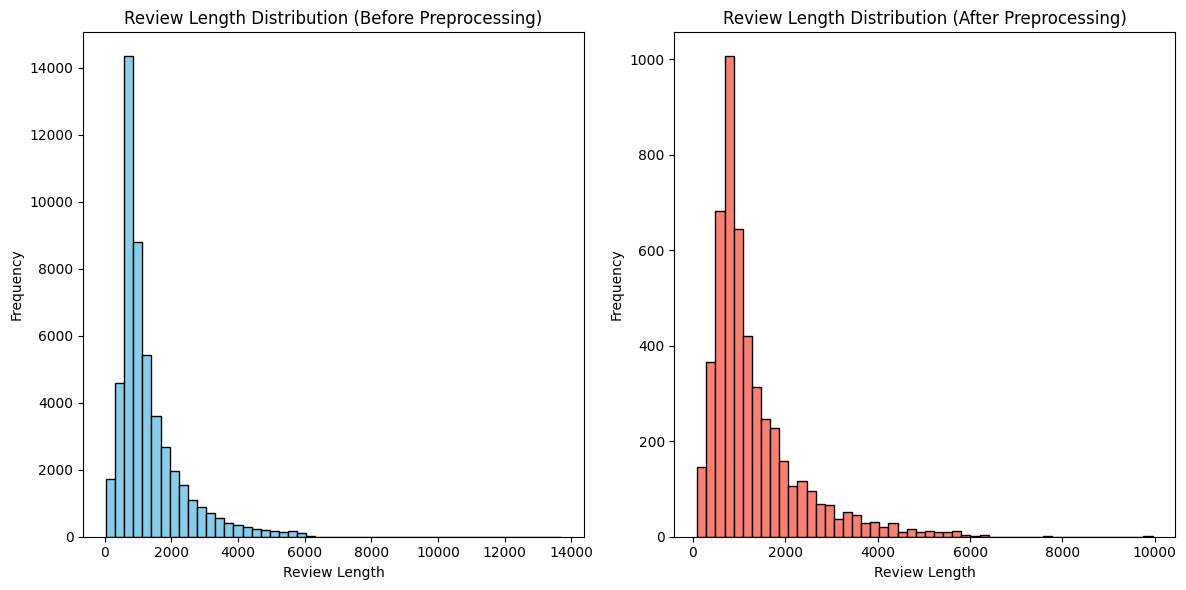

In [36]:
import matplotlib.pyplot as plt

# Plot histograms for review length distribution before and after preprocessing
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['review_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Review Length Distribution (Before Preprocessing)')
plt.xlabel('Review Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(eval_df['review_length'], bins=50, color='salmon', edgecolor='black')  # Use eval_df instead of train_df
plt.title('Review Length Distribution (After Preprocessing)')
plt.xlabel('Review Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

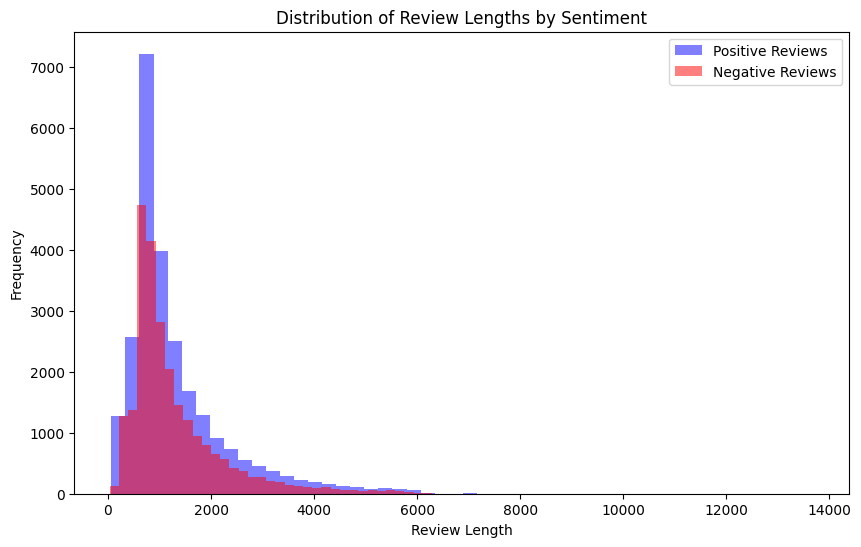

In [35]:
import matplotlib.pyplot as plt

# Plot the distribution of review lengths for positive and negative reviews separately
plt.figure(figsize=(10, 6))
plt.hist(df[df['sentiment'] == 'positive']['review_length'], bins=50, color='blue', alpha=0.5, label='Positive Reviews')
plt.hist(df[df['sentiment'] == 'negative']['review_length'], bins=50, color='red', alpha=0.5, label='Negative Reviews')
plt.title('Distribution of Review Lengths by Sentiment')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

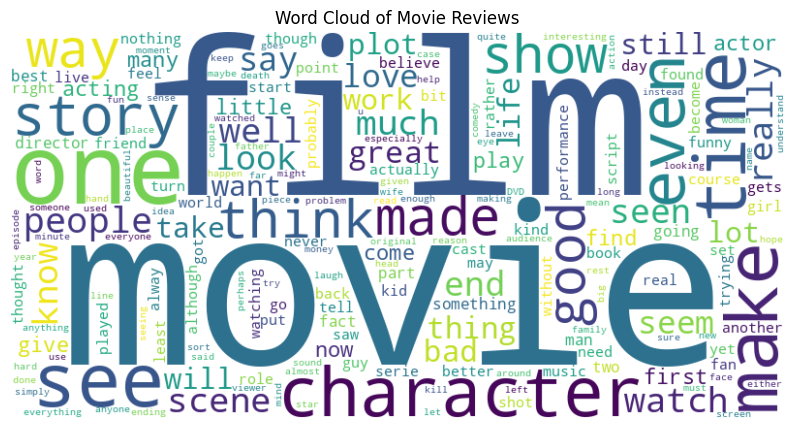

In [32]:
from wordcloud import WordCloud

# Concatenate all reviews into a single string
all_reviews = ' '.join(df['review'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Movie Reviews')
plt.axis('off')
plt.show()

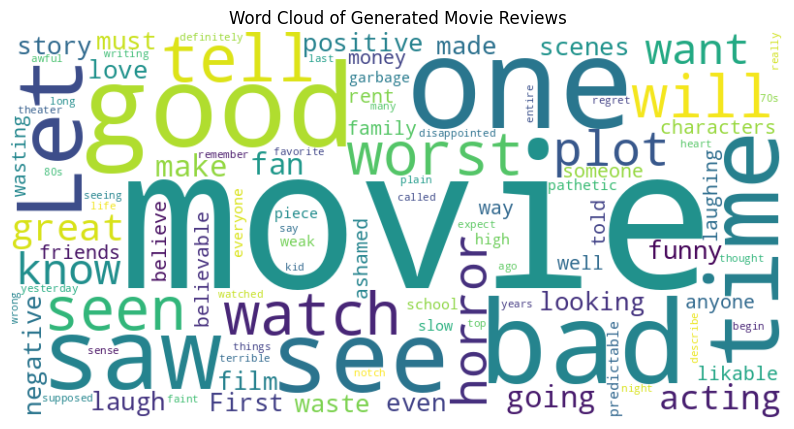

In [33]:
from wordcloud import WordCloud

# Concatenate all generated reviews into a single string
all_generated_reviews = ' '.join(hypotheses)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_generated_reviews)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Generated Movie Reviews')
plt.axis('off')
plt.show()